<a href="https://colab.research.google.com/github/victor-mora/ExemplaryLearning/blob/main/Final_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical  
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [ ]:
train, test = tfds.load(name='mnist',split=['train', 'test'], shuffle_files=True)
#get all the data
trainingimgs = []
traininglab = []
for i in train:
  trainingimgs.append(i['image'])
  traininglab.append(i['label'])
train_imgs = tf.convert_to_tensor(trainingimgs, dtype = tf.float32)/255
train_labels = tf.convert_to_tensor(traininglab, dtype = tf.int32)
train_labels = to_categorical(train_labels, num_classes=10)

testingimgs = []
testinglab = []
for i in test:
  testingimgs.append(i['image'])
  testinglab.append(i['label'])
test_imgs = tf.convert_to_tensor(testingimgs, dtype = tf.float32)/255
test_labels = tf.convert_to_tensor(testinglab)
test_labels = to_categorical(test_labels, num_classes=10)


In [ ]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    self.batch_size = 100
    self.initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1)
    self.conv1 = tf.keras.layers.Conv2D(10,5,1,padding = 'same',kernel_initializer=self.initializer, activation='relu')
    self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="same")
    self.conv2 = tf.keras.layers.Conv2D(1,3,1,padding = 'same',kernel_initializer=self.initializer, activation='relu')
    self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="same")
    self.numproto = 20
    self.prototypes = tf.Variable(tf.random.truncated_normal(shape=[10,self.numproto,7,7], stddev=.05, dtype=tf.float32))
    self.gamma = 1.0 #tf.Variable(tf.random.truncated_normal(shape=(), stddev=.05, dtype=tf.float32))
    self.lambs = 0.001 #tf.Variable(tf.random.truncated_normal(shape=(), stddev=.05, dtype=tf.float32))

  def get_distance(self,inputs):
    batch_cnn_extracts = tf.reshape(inputs, [self.batch_size,7,7])
    classdist = []
    for i in range(10):
      classprotodist = []
      for j in range(self.numproto):
          current_prototype = self.prototypes[i,j,:]
          difference = tf.math.reduce_sum(tf.math.square(batch_cnn_extracts - current_prototype), axis = [1,2])#should be 100x1 for batch by 1 number rep diff
          classprotodist.append(difference)
      classprotodist = tf.stack(classprotodist)
      classdist.append(classprotodist)
    return tf.stack(classdist)#should be 10x10x100x1 or 10x10x100
  def get_min_distance(self,puredist):
    classbestdist = -1*tf.math.reduce_min(puredist,axis = 1)
    return classbestdist#should be 10x100x1

  def classify_forward(self,mindistances):
    labs = tf.math.argmax(mindistances,axis = 0)#should be 100x1 now
    onehots = to_categorical(labs, num_classes=10)
    return onehots


  def feature_extract(self, inputs):
    cv1 = self.conv1(inputs)
    pool1 = self.pool1(cv1)
    cv2 = self.conv2(pool1)
    pool2 = self.pool2(cv2)
    return pool2
  def call(self,inputs):
    pool2 = self.feature_extract(inputs)
    return self.classify_forward(self.get_min_distance(self.get_distance(pool2)))

  def loss(self, inputs, labels):
    #implement dce + pl
    #neg_log_likelihood = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    #kl = sum(self.losses)
    #loss = neg_log_likelihood + kl
    pool2 = self.feature_extract(inputs)
    plaindist = self.get_distance(pool2)
    dists = -1 * self.gamma* plaindist
    softmaxed = tf.nn.softmax(dists)
    #should be same shape as dists
    perclass = tf.math.reduce_sum(softmaxed, axis = 1)
    #probs = tf.reshape(perclass, [10,self.batch_size,1])#10x100x1
    #transp = tf.transpose(perclass) #[1, 0, 2])
    reshape2 = tf.reshape(perclass,[10,self.batch_size])#tf.reshape(transp,[self.batch_size,10])
    #loss = tf.keras.losses.categorical_crossentropy(reshape2, labels)
    #now get pl loss
    bestdist = -1* self.get_min_distance(plaindist)
    index = tf.math.argmax(labels, axis=1,output_type=tf.dtypes.int32)
    gathers = tf.stack([index,tf.range(0, tf.shape(labels)[0])], axis=1)
    loss = -1* tf.math.log(tf.gather_nd(reshape2,gathers))
    result = tf.gather_nd(bestdist, gathers)
    #assert(result >0)
    return tf.reduce_mean(loss + self.lambs*result)#maybe this boosts acc?


In [ ]:
def train(model, train_inputs, train_labels):
  num_examples = train_labels.shape[0]
  avgloss = 0
  counter = 0
  for i in range(0,num_examples,model.batch_size):
      if(i + model.batch_size < num_examples):
          with tf.GradientTape() as tape:
              #predictions = model(train_inputs[i:i+model.batch_size])
              loss = model.loss(train_inputs[i:i+model.batch_size], train_labels[i:i+model.batch_size])
              avgloss += loss#tf.reduce_mean(loss)
              counter +=1
          gradients = tape.gradient(loss, model.trainable_variables)
          model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  print(avgloss/counter)
def test(model, test_inputs, test_labels):
  num_examples = test_labels.shape[0]
  acclist = []
  for i in range(0,num_examples,model.batch_size):
      if(i + model.batch_size < num_examples):
          predictions = model(test_inputs[i:i+model.batch_size])
          truths = tf.math.multiply(predictions,test_labels[i:i+model.batch_size])
          num_corr = tf.math.reduce_sum(truths)
          acc = num_corr/model.batch_size
          acclist.append(acc)
  return acclist

In [ ]:
model = Model()
for l in range(8):
  train(model, train_imgs,train_labels)

tf.Tensor(0.5894714, shape=(), dtype=float32)
tf.Tensor(0.00585899, shape=(), dtype=float32)
tf.Tensor(-0.15104425, shape=(), dtype=float32)
tf.Tensor(-0.2353516, shape=(), dtype=float32)
tf.Tensor(-0.28303537, shape=(), dtype=float32)
tf.Tensor(-0.31496605, shape=(), dtype=float32)
tf.Tensor(-0.33817202, shape=(), dtype=float32)
tf.Tensor(-0.3557821, shape=(), dtype=float32)


In [ ]:
acclist = tf.convert_to_tensor(test(model,test_imgs,test_labels))
print(tf.math.reduce_mean(acclist))

tf.Tensor(0.82818186, shape=(), dtype=float32)


In [ ]:
print(acclist)

tf.Tensor(
[0.84 0.86 0.83 0.83 0.91 0.78 0.85 0.83 0.88 0.82 0.88 0.81 0.87 0.83
 0.82 0.81 0.85 0.75 0.82 0.84 0.84 0.84 0.86 0.86 0.84 0.87 0.82 0.75
 0.81 0.76 0.78 0.83 0.79 0.84 0.8  0.85 0.83 0.78 0.81 0.77 0.8  0.87
 0.79 0.86 0.81 0.84 0.88 0.87 0.77 0.84 0.86 0.83 0.84 0.85 0.82 0.85
 0.88 0.83 0.84 0.85 0.82 0.9  0.84 0.78 0.81 0.87 0.85 0.77 0.77 0.85
 0.84 0.8  0.77 0.86 0.8  0.85 0.84 0.9  0.82 0.77 0.84 0.82 0.85 0.89
 0.87 0.79 0.79 0.8  0.86 0.77 0.79 0.79 0.88 0.83 0.81 0.85 0.84 0.79
 0.8 ], shape=(99,), dtype=float32)


In [ ]:
#future idea, use ssim instead of meansquare, add probabilistic layers just cause for probabilistic use tfp tensorflow probability

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.L1_W = tf.Variable(tf.random.truncated_normal([4,4,10,10], stddev=.1))
        self.L1_b = tf.Variable(tf.random.truncated_normal(shape=[10], stddev=.1))

        self.leakyrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.initial = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1)
        
        self.decoder_deconv_2 = tf.keras.layers.Conv2DTranspose(10, 3, 2, padding="same", kernel_initializer=self.initial, activation=self.leakyrelu)
        self.decoder_deconv_3 = tf.keras.layers.Conv2DTranspose(1, 3, 2, padding="same", kernel_initializer=self.initial, activation=self.leakyrelu)
        #kgkgkg + not sure if enc or dec correct
        
    
        
    
    @tf.function
    def call(self, encoder_output):
        
        batchSz = tf.shape(encoder_output)[0]
        # TODO fill in the first layer of convolution transpose
        # hint: use tf.stack when creating the output shape parameter
        #       in conv2d_transpose
        #deconv = tf.stack(tf.nn.conv2d_transpose(encoder_output, self.L1_W, (batchSz, 7, 7,10), 2, padding="SAME"))
        deconv = tf.nn.conv2d_transpose(encoder_output, self.L1_W, tf.stack([batchSz, 7, 7,10]), 2, padding="SAME")
        #how to use tf.stack in shape parameter?? tf.stack([tf.shape(x)[0], shape[1], shape[2], shape[3]])
        deconv = tf.add(deconv, self.L1_b)
        results = tf.nn.leaky_relu(deconv)
        
        # TODO rest of transposed-convolution layers
        de2 = self.decoder_deconv_2(results)
        de3 = self.decoder_deconv_3(de2)
        
        return de3

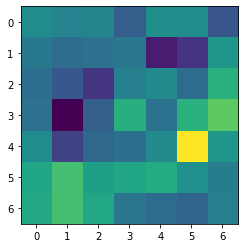

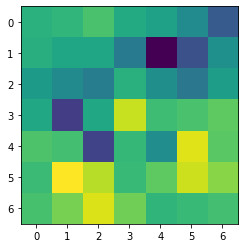

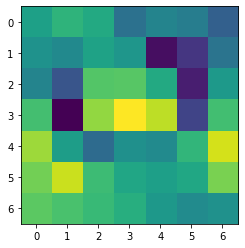

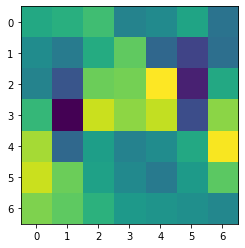

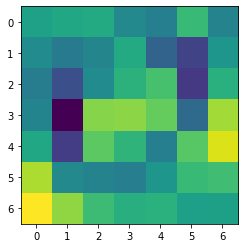

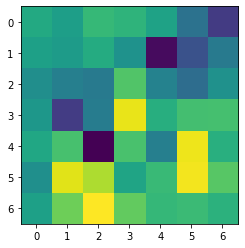

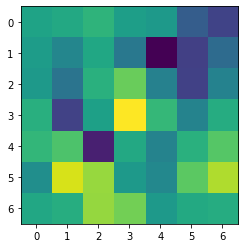

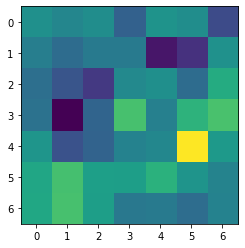

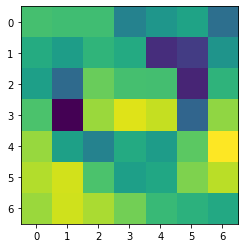

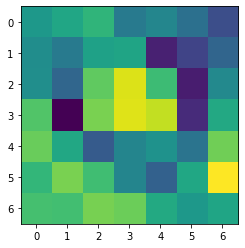

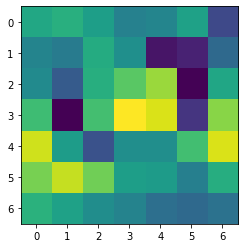

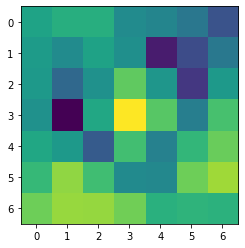

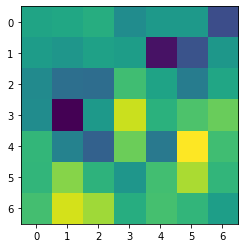

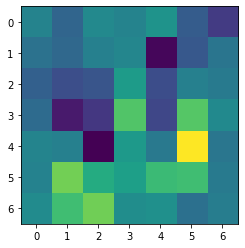

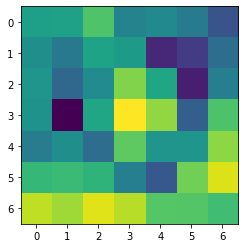

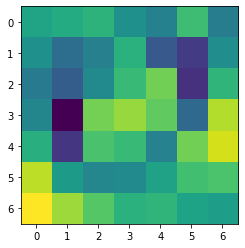

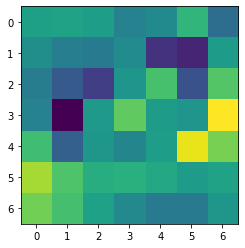

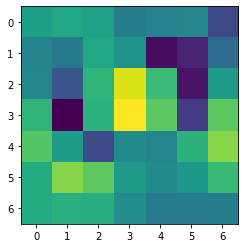

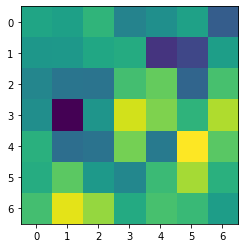

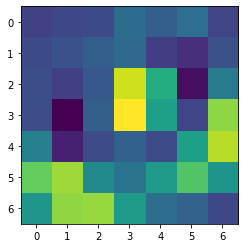

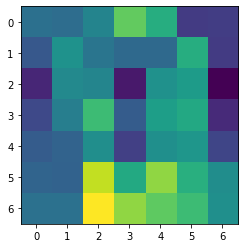

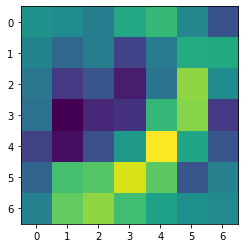

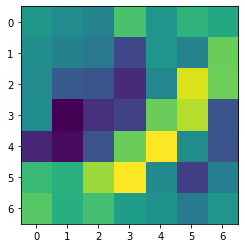

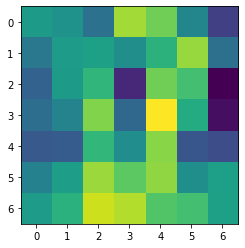

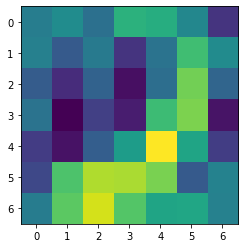

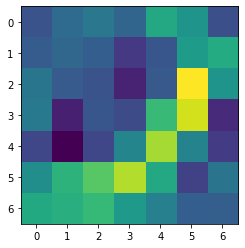

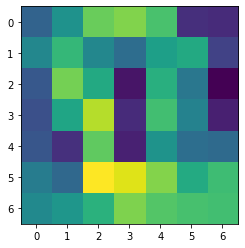

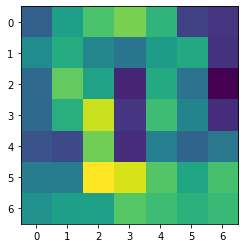

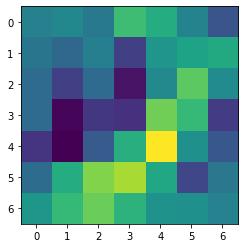

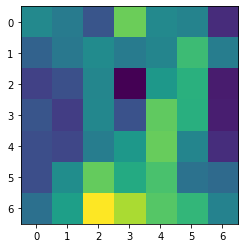

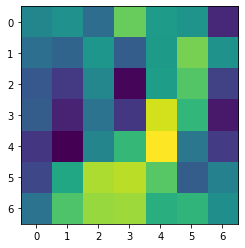

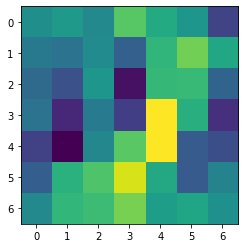

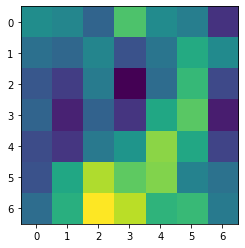

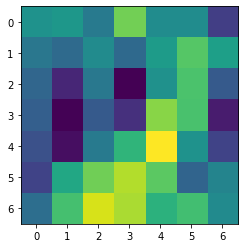

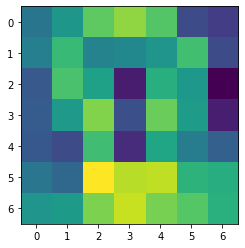

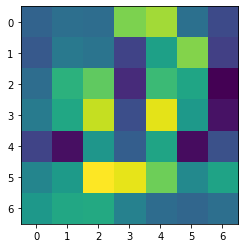

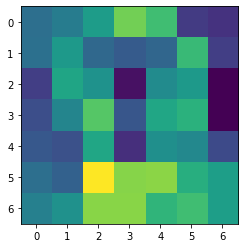

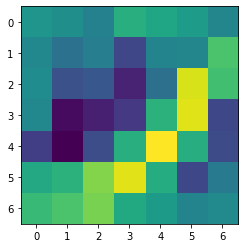

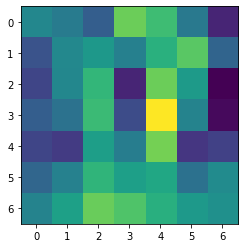

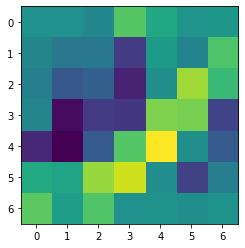

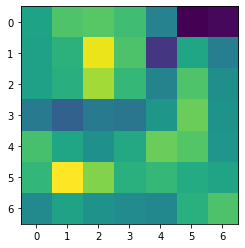

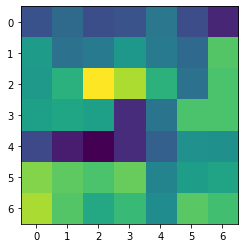

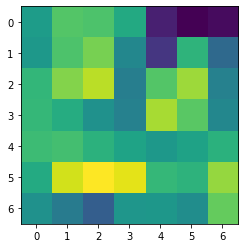

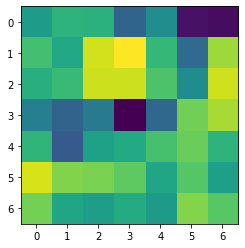

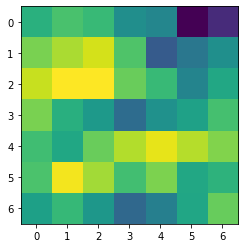

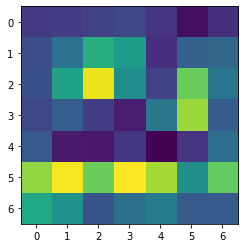

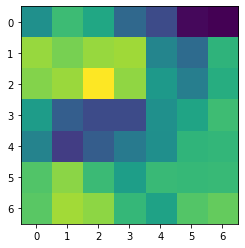

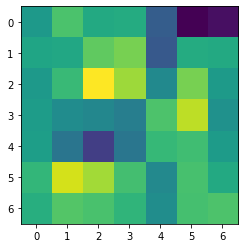

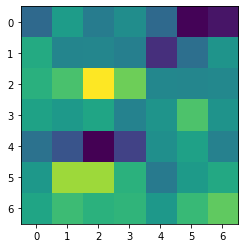

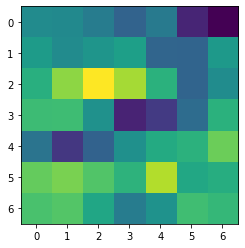

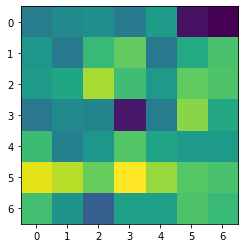

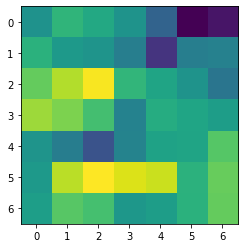

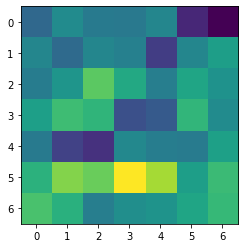

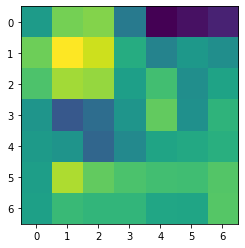

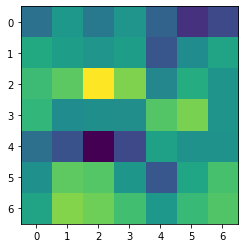

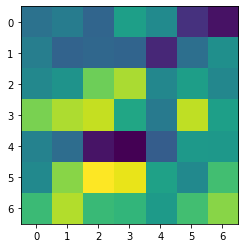

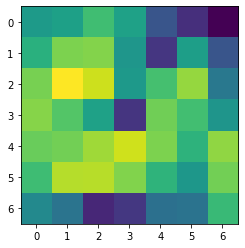

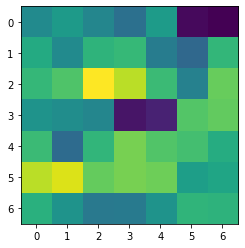

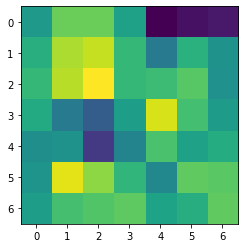

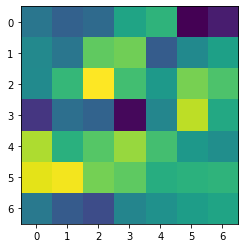

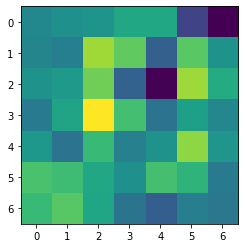

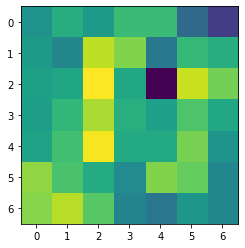

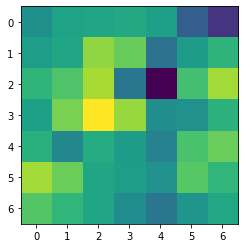

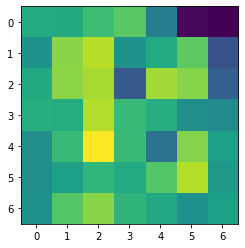

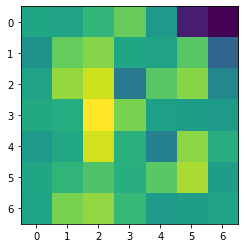

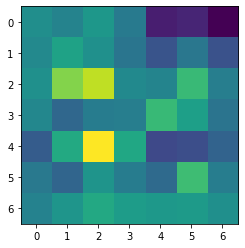

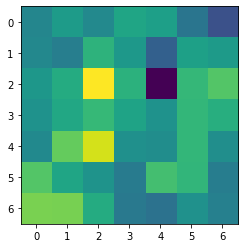

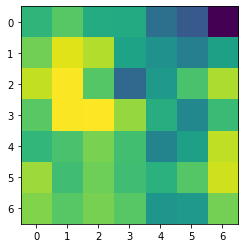

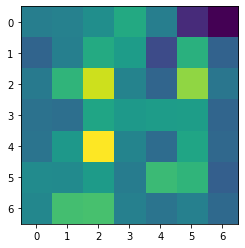

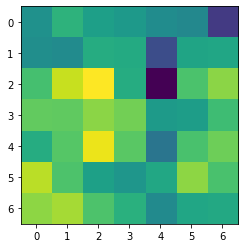

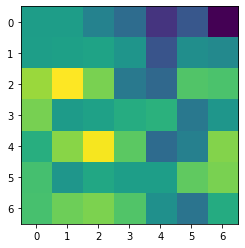

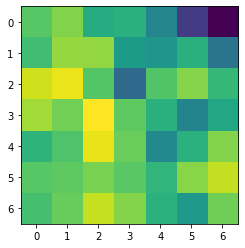

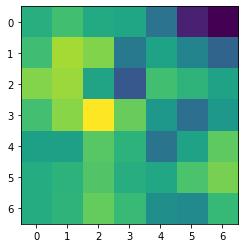

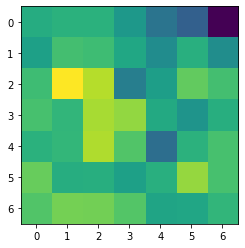

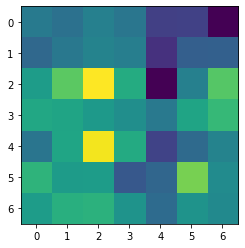

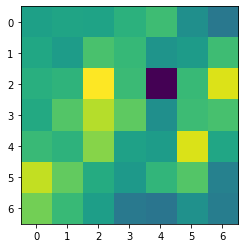

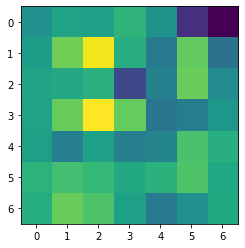

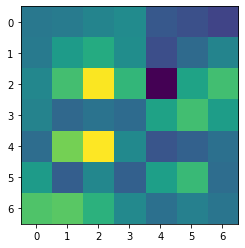

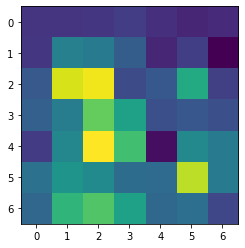

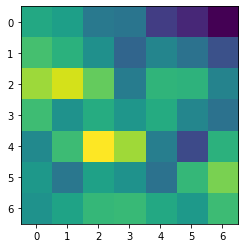

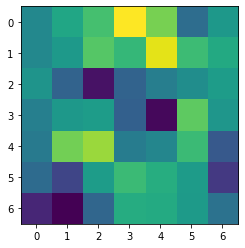

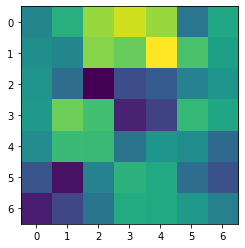

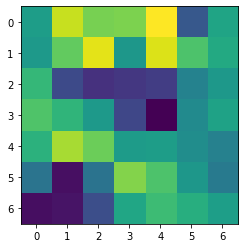

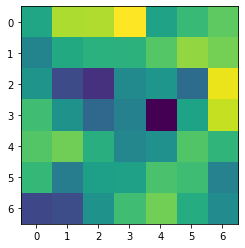

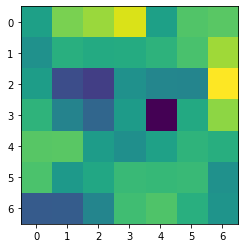

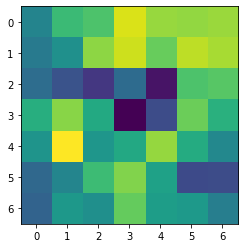

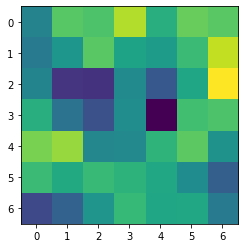

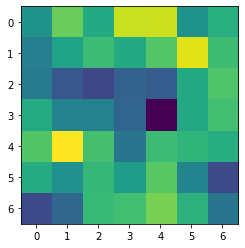

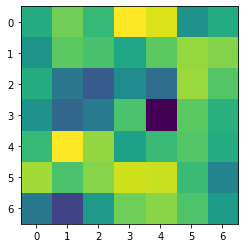

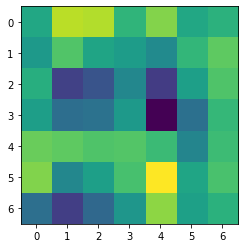

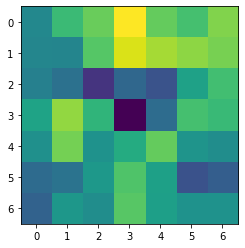

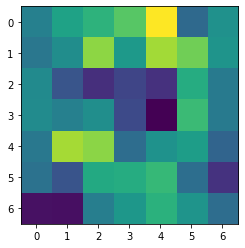

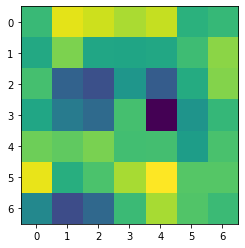

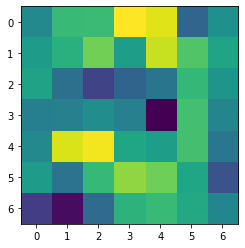

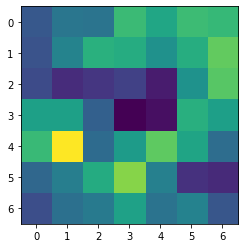

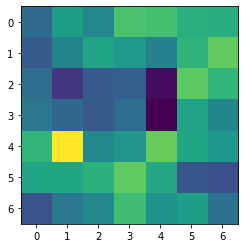

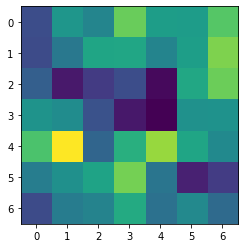

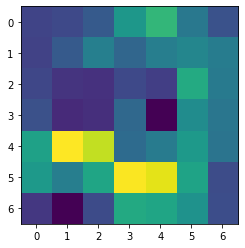

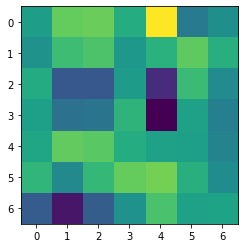

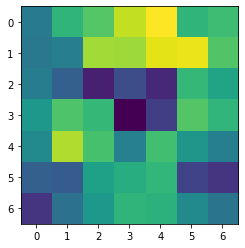

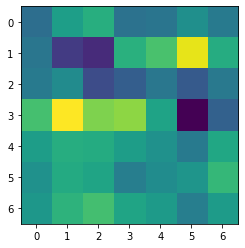

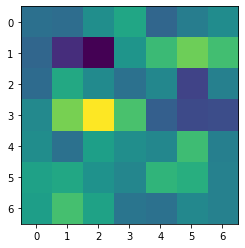

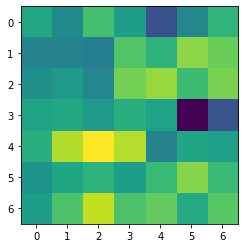

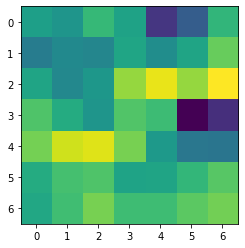

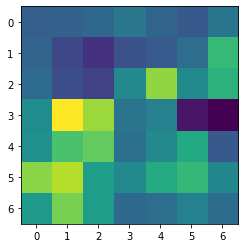

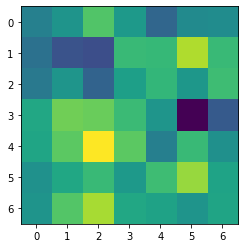

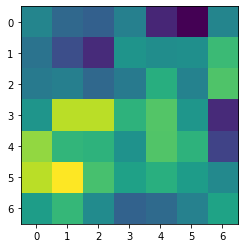

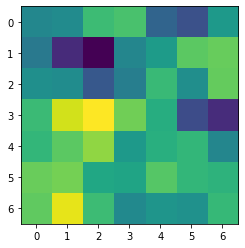

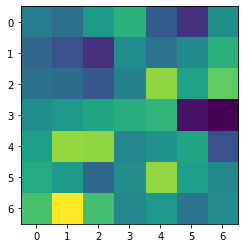

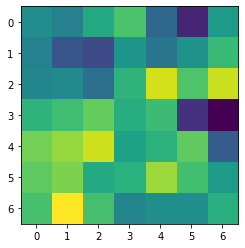

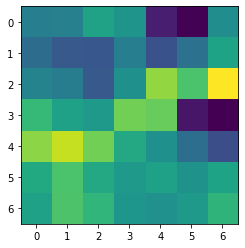

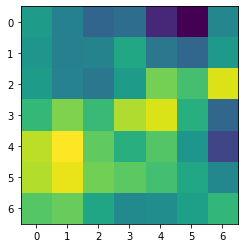

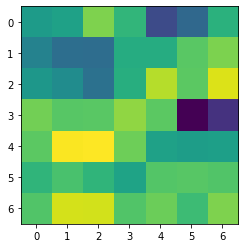

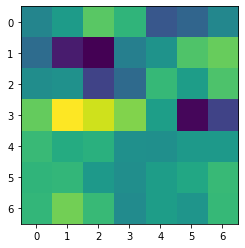

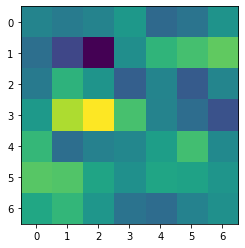

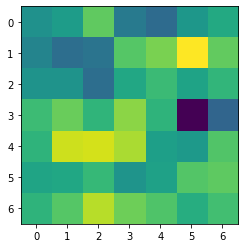

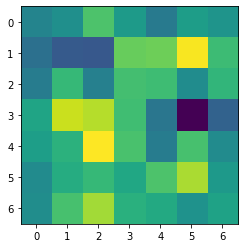

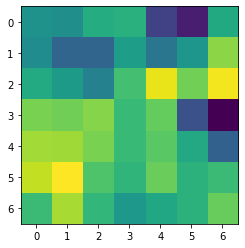

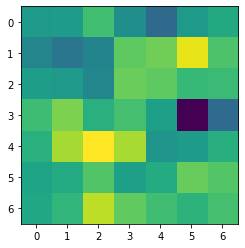

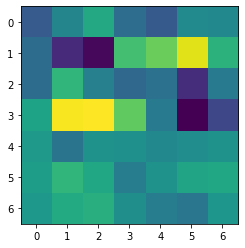

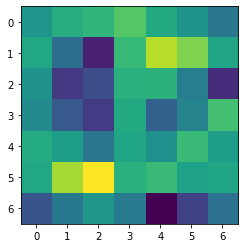

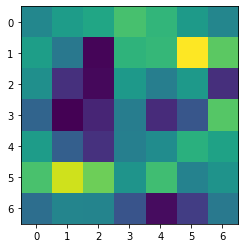

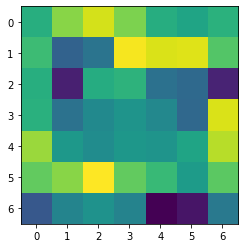

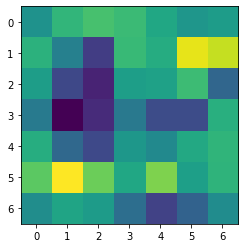

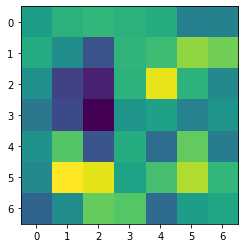

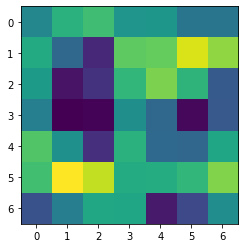

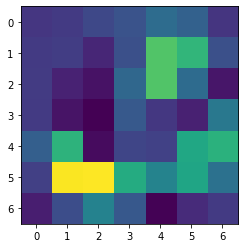

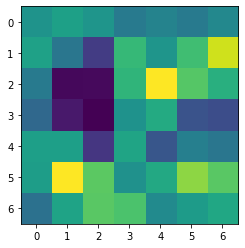

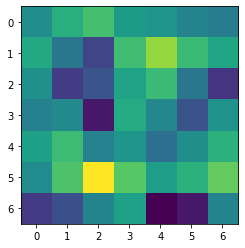

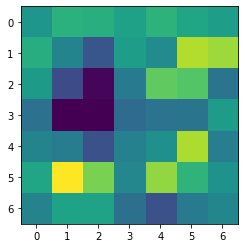

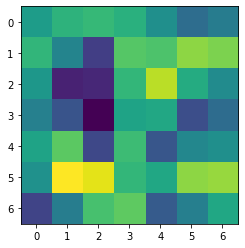

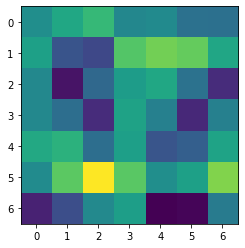

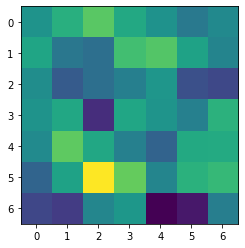

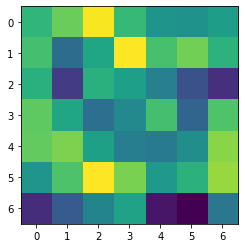

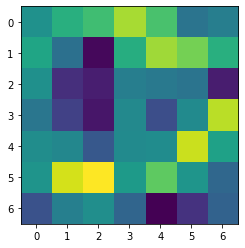

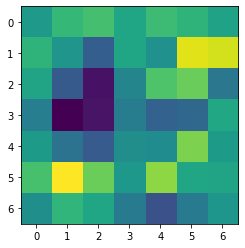

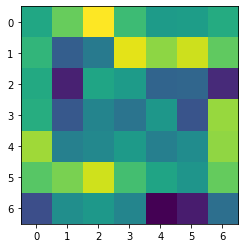

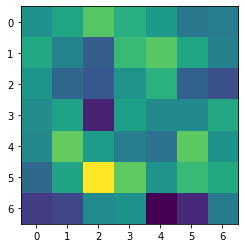

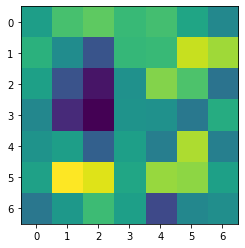

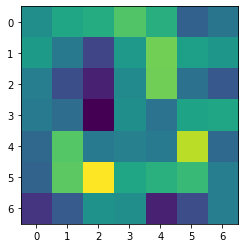

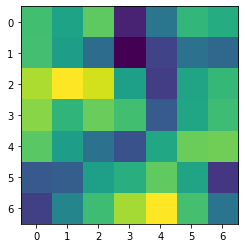

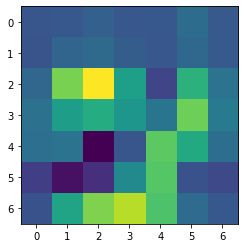

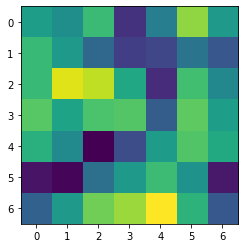

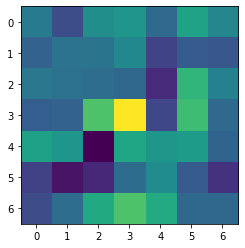

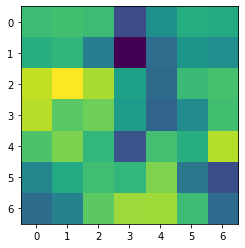

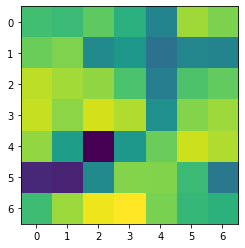

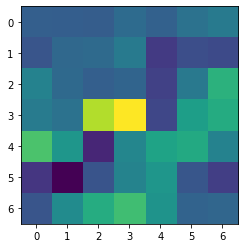

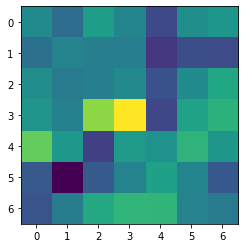

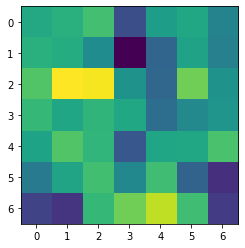

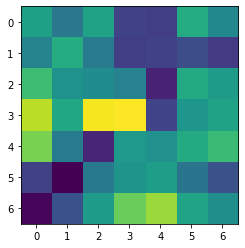

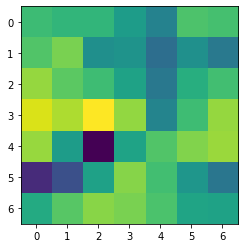

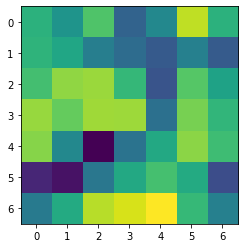

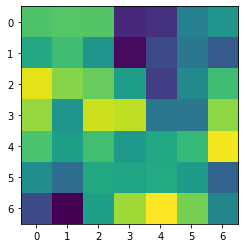

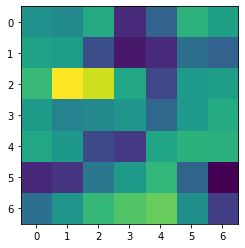

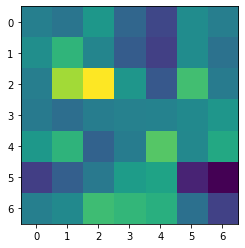

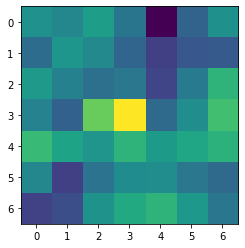

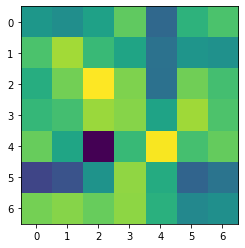

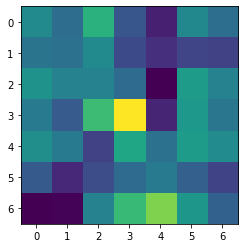

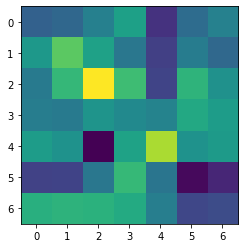

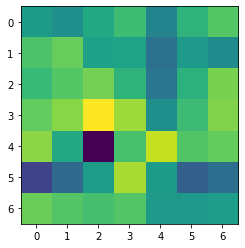

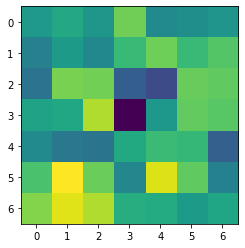

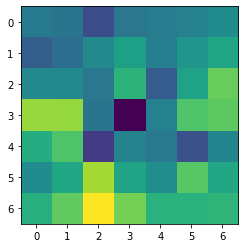

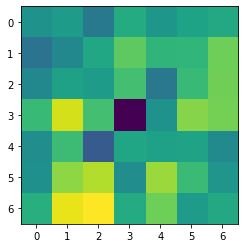

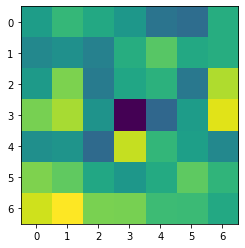

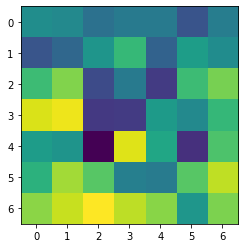

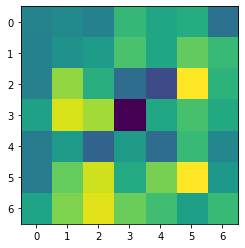

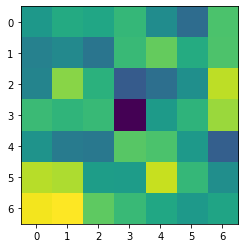

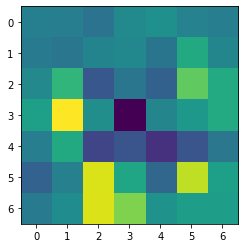

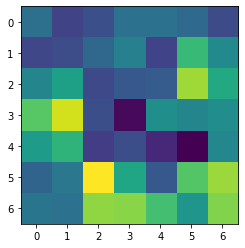

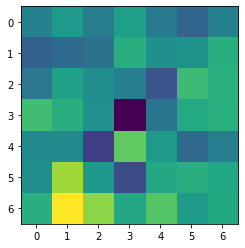

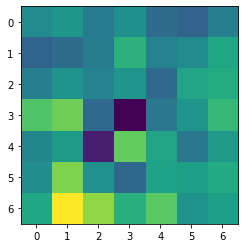

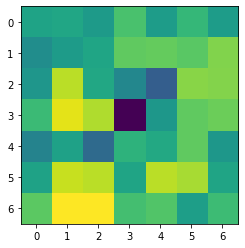

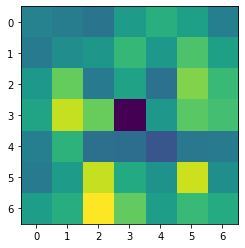

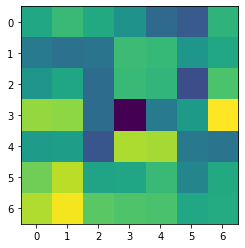

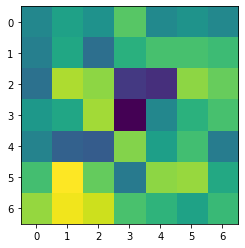

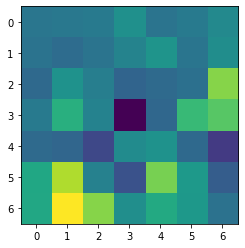

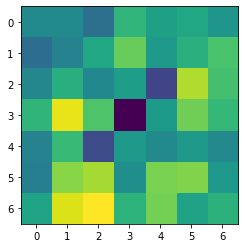

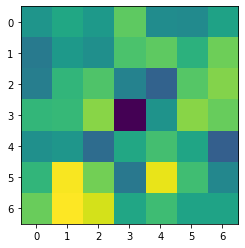

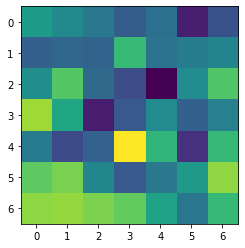

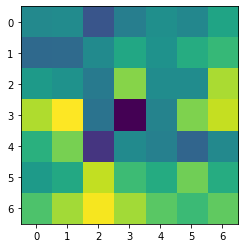

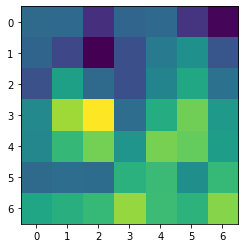

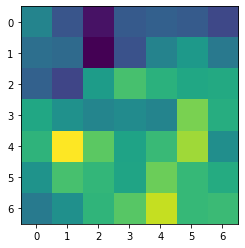

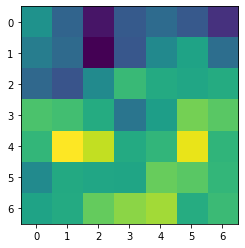

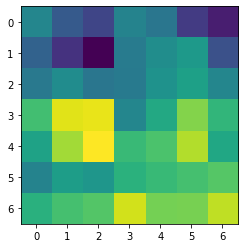

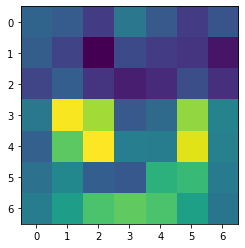

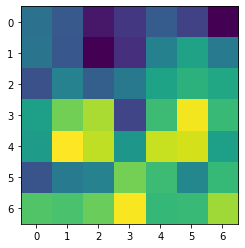

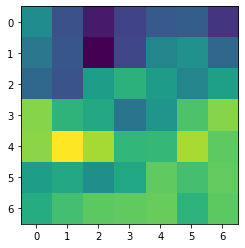

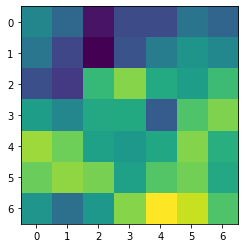

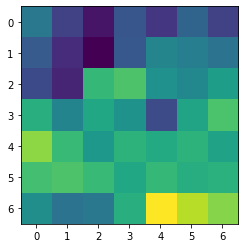

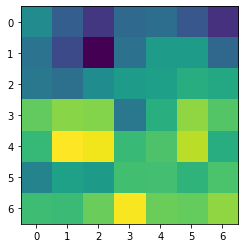

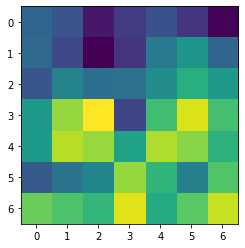

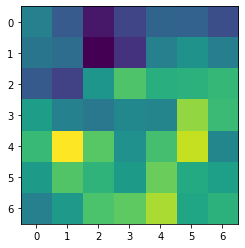

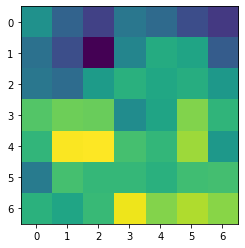

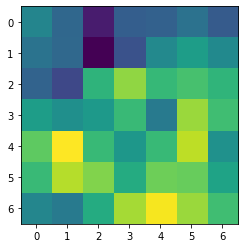

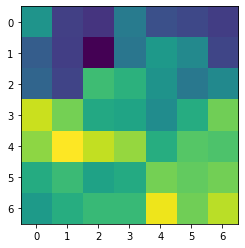

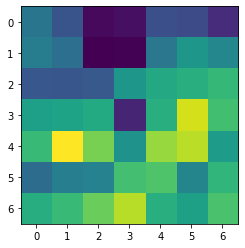

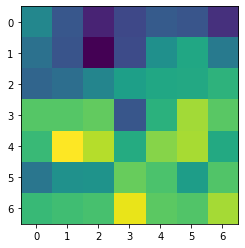

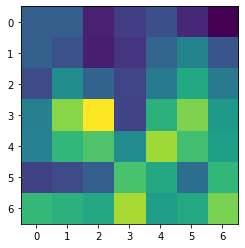

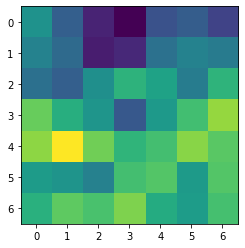

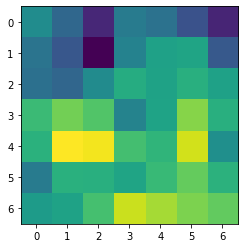

In [ ]:
gathers = tf.stack([tf.range(0, 10),tf.range(0, 10)], axis=1)
for i in range(10):
  for j in range(20):
    proto = model.prototypes[i][j].numpy()
    plt.imshow(proto)
    plt.show()
#want to get back an image from these features?
